In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import json
import folium
import branca.colormap as cm
import shap
import dalex as dx
from xgboost import XGBRegressor
from sklearn.metrics import PredictionErrorDisplay
from sklearn.feature_selection import RFECV, RFE
from sklearn.model_selection import train_test_split, cross_validate, RandomizedSearchCV
from sklearn.neighbors import BallTree


warnings.simplefilter(action="ignore", category=FutureWarning)
pd.set_option("display.max_columns", 100)
pd.set_option("display.max_rows", 100)

# Function to read a subset of the JSON data from two files and combine them
def read_json_subset(file_name1, file_name2, n=10000):
    chunk1 = []
    chunk2 = []

    # Read the first file
    with open(file_name1, "r", encoding="utf-8") as f1:
        for _ in range(n):
            line = f1.readline()
            if not line:
                break
            chunk1.append(json.loads(line))

    # Read the second file
    with open(file_name2, "r", encoding="utf-8") as f2:
        for _ in range(n):
            line = f2.readline()
            if not line:
                break
            chunk2.append(json.loads(line))

    # Combine the chunks
    combined_chunk = chunk1 + chunk2

    return pd.DataFrame(combined_chunk)


# Load dataset from two files
business_df = read_json_subset(
    "yelp_dataset/business1.json", "yelp_dataset/business2.json", 200000
)

In [2]:
# drop not open businesses
business_df = business_df[business_df["is_open"] == 1]

In [3]:
business_df

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
1,mpf3x-BjTdTEA3yCZrAYPw,The UPS Store,87 Grasso Plaza Shopping Center,Affton,MO,63123,38.551126,-90.335695,3.0,15,1,{'BusinessAcceptsCreditCards': 'True'},"Shipping Centers, Local Services, Notaries, Ma...","{'Monday': '0:0-0:0', 'Tuesday': '8:0-18:30', ..."
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,1,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...","Restaurants, Food, Bubble Tea, Coffee & Tea, B...","{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ..."
4,mWMc6_wTdE0EUBKIGXDVfA,Perkiomen Valley Brewery,101 Walnut St,Green Lane,PA,18054,40.338183,-75.471659,4.5,13,1,"{'BusinessAcceptsCreditCards': 'True', 'Wheelc...","Brewpubs, Breweries, Food","{'Wednesday': '14:0-22:0', 'Thursday': '16:0-2..."
5,CF33F8-E6oudUQ46HnavjQ,Sonic Drive-In,615 S Main St,Ashland City,TN,37015,36.269593,-87.058943,2.0,6,1,"{'BusinessParking': 'None', 'BusinessAcceptsCr...","Burgers, Fast Food, Sandwiches, Food, Ice Crea...","{'Monday': '0:0-0:0', 'Tuesday': '6:0-22:0', '..."
6,n_0UpQx1hsNbnPUSlodU8w,Famous Footwear,"8522 Eager Road, Dierbergs Brentwood Point",Brentwood,MO,63144,38.627695,-90.340465,2.5,13,1,"{'BusinessAcceptsCreditCards': 'True', 'Restau...","Sporting Goods, Fashion, Shoe Stores, Shopping...","{'Monday': '0:0-0:0', 'Tuesday': '10:0-18:0', ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150341,IUQopTMmYQG-qRtBk-8QnA,Binh's Nails,3388 Gateway Blvd,Edmonton,AB,T6J 5H2,53.468419,-113.492054,3.0,13,1,"{'ByAppointmentOnly': 'False', 'RestaurantsPri...","Nail Salons, Beauty & Spas","{'Monday': '10:0-19:30', 'Tuesday': '10:0-19:3..."
150342,c8GjPIOTGVmIemT7j5_SyQ,Wild Birds Unlimited,2813 Bransford Ave,Nashville,TN,37204,36.115118,-86.766925,4.0,5,1,"{'BusinessAcceptsCreditCards': 'True', 'Restau...","Pets, Nurseries & Gardening, Pet Stores, Hobby...","{'Monday': '9:30-17:30', 'Tuesday': '9:30-17:3..."
150343,_QAMST-NrQobXduilWEqSw,Claire's Boutique,"6020 E 82nd St, Ste 46",Indianapolis,IN,46250,39.908707,-86.065088,3.5,8,1,"{'RestaurantsPriceRange2': '1', 'BusinessAccep...","Shopping, Jewelry, Piercing, Toy Stores, Beaut...",None
150344,mtGm22y5c2UHNXDFAjaPNw,Cyclery & Fitness Center,2472 Troy Rd,Edwardsville,IL,62025,38.782351,-89.950558,4.0,24,1,"{'BusinessParking': '{'garage': False, 'street...","Fitness/Exercise Equipment, Eyewear & Optician...","{'Monday': '9:0-20:0', 'Tuesday': '9:0-20:0', ..."


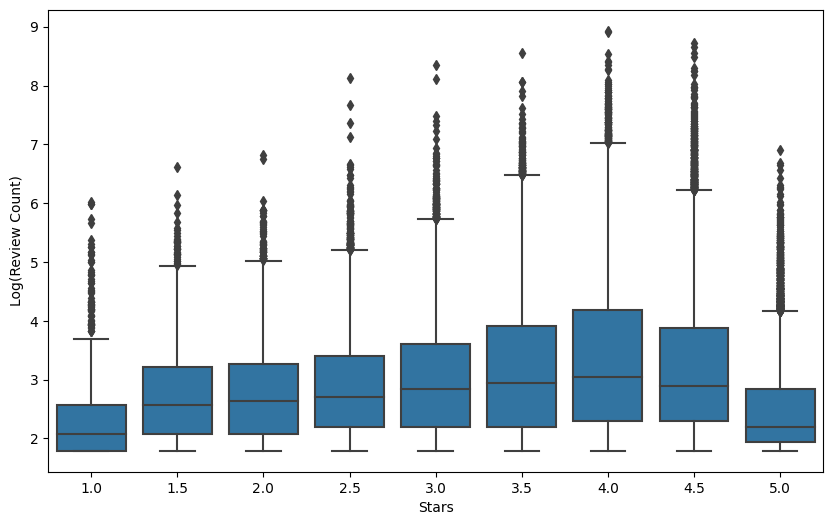

In [4]:
# bar plot of review count to stars blue

log_review_count = np.log(business_df["review_count"] + 1)
plt.figure(figsize=(10, 6))
sns.boxplot(x="stars", y=log_review_count, data=business_df, color="#1f77b4")

plt.xlabel("Stars")
plt.ylabel("Log(Review Count)")

plt.show()


<AxesSubplot: >

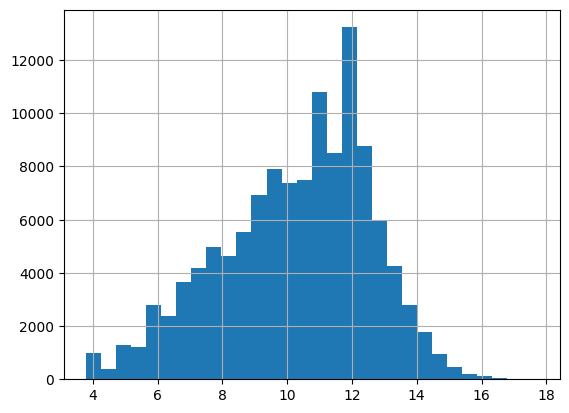

In [5]:
# Adjusting the business success score calculation
# Assuming alpha = 2 (weight for stars) and beta = 1 (weight for review count, using log scale here)
alpha = 2
beta = 1

business_df["business_success_score"] = (alpha * business_df["stars"]) + (
    beta * np.log(business_df["review_count"] + 1)
)

# Plotting the histogram of the business success score
business_df["business_success_score"].hist(bins=30)

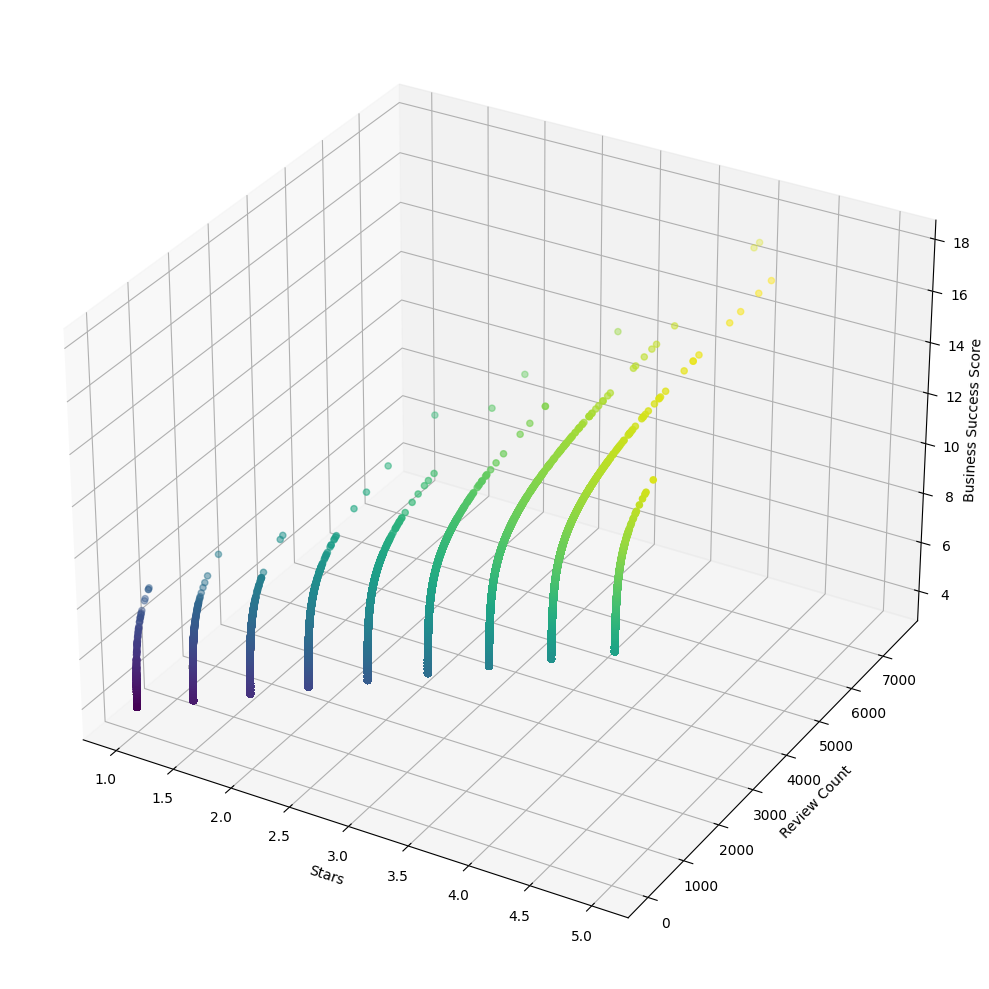

In [6]:
fig = plt.figure(figsize=(14, 10))

ax = fig.add_subplot(111, projection="3d")

x = business_df["stars"]
y = business_df["review_count"]
z = business_df["business_success_score"]

# Plot the data
sc = ax.scatter(x, y, z, c=z, marker="o")

ax.set_xlabel("Stars")
ax.set_ylabel("Review Count")
ax.set_zlabel("Business Success Score", labelpad=0)
plt.tight_layout()

plt.show()

In [ ]:
# Create a map centered around the average location
m = folium.Map(
    location=[business_df["latitude"].mean(), business_df["longitude"].mean()],
    zoom_start=5,
    tiles="CartoDB positron",
)

colormap = cm.LinearColormap(
    colors=["red", "yellow", "green"],
    vmin=business_df["business_success_score"].min(),
    vmax=business_df["business_success_score"].max(),
)


# Add color legend to the map
colormap.caption = "Business Score"
m.add_child(colormap)

# Add markers to the map
for idx, row in business_df.iterrows():
    folium.Circle(
        location=[row["latitude"], row["longitude"]],
        radius=10,
        popup=f"Business Score: {row['business_success_score']}",
        color=colormap(row["business_success_score"]),
        fill=True,
        fill_color=colormap(row["business_success_score"]),
    ).add_to(m)

m

In [8]:
business_df["business_success_score"].describe()

count    119698.000000
mean         10.266713
std           2.313319
min           3.791759
25%           8.791759
50%          10.610918
75%          11.945910
max          17.715060
Name: business_success_score, dtype: float64

In [9]:
# show business with the highest success score
business_df.nlargest(5, "business_success_score")

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours,business_success_score
91757,GXFMD0Z4jEVZBCsbPf4CTQ,Hattie B’s Hot Chicken - Nashville,112 19th Ave S,Nashville,TN,37203,36.151387,-86.796603,4.5,6093,1,"{'RestaurantsGoodForGroups': 'True', 'Business...","American (Traditional), Chicken Shop, Southern...","{'Monday': '0:0-0:0', 'Tuesday': '11:0-16:0', ...",17.715060
143157,ytynqOUb3hjKeJfRj5Tshw,Reading Terminal Market,51 N 12th St,Philadelphia,PA,19107,39.953341,-75.158855,4.5,5721,1,"{'RestaurantsGoodForGroups': 'True', 'Restaura...","Candy Stores, Shopping, Department Stores, Fas...","{'Monday': '8:0-18:0', 'Tuesday': '8:0-18:0', ...",17.652074
147081,oBNrLz4EDhiscSlbOl8uAw,Ruby Slipper - New Orleans,200 Magazine St,New Orleans,LA,70130,29.951025,-90.067394,4.5,5193,1,"{'NoiseLevel': ''loud'', 'Caters': 'False', 'B...","Restaurants, American (Traditional), American ...","{'Monday': '0:0-0:0', 'Tuesday': '7:30-14:0', ...",17.555259
31332,_C7QiQQc47AOEv4PE3Kong,Commander's Palace,1403 Washington Ave,New Orleans,LA,70130,29.928735,-90.084196,4.5,4876,1,"{'RestaurantsGoodForGroups': 'True', 'OutdoorS...","French, Restaurants, Cocktail Bars, Nightlife,...","{'Monday': '0:0-0:0', 'Tuesday': '18:0-21:30',...",17.492286
132673,I_3LMZ_1m2mzR0oLIOePIg,Pappy's Smokehouse,3106 Olive St,Saint Louis,MO,63103,38.635147,-90.224003,4.5,3999,1,"{'Alcohol': 'u'none'', 'RestaurantsAttire': ''...","Food, Restaurants, Caterers, Smokehouse, Barbe...","{'Monday': '0:0-0:0', 'Tuesday': '11:0-16:0', ...",17.294050


In [10]:
# show business with the lowest success score
business_df.nsmallest(5, "business_success_score")

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours,business_success_score
744,ygnm0ze5oL4E9JpysZAxBA,Absolute Luxury,,Tampa Bay,FL,33578,27.858576,-82.339764,1.0,5,1,{'BusinessAcceptsCreditCards': 'True'},"Limos, Party Bus Rentals, Transportation, Hote...","{'Monday': '8:0-0:0', 'Tuesday': '8:0-0:0', 'W...",3.791759
1297,y8GId04Q7slRzgFYq-Yvkg,Tuchman Cleaners,378 Western Blvd,Greenwood,IN,46142,39.619064,-86.211680,1.0,5,1,"{'BikeParking': 'True', 'BusinessParking': '{'...","Dry Cleaning & Laundry, Laundry Services, Shoe...","{'Monday': '7:0-18:0', 'Tuesday': '7:0-19:0', ...",3.791759
1665,ZR7jsiG-jZHSIgegdKN-qA,Lincare,19387 US 19 N,Clearwater,FL,33764,27.949066,-82.728282,1.0,5,1,None,"Doctors, Health & Medical, Pediatricians",None,3.791759
2018,0ftdaqwh-U4m9Mmdj9Z_AA,Copart,13033 Taussig Ave,Bridgeton,MO,63044,38.778509,-90.423581,1.0,5,1,None,"Automotive, Car Auctions","{'Monday': '8:0-17:0', 'Tuesday': '8:0-17:0', ...",3.791759
2032,PGCTib7KxDctvNnQry_iDA,Majestic Ballroom,800 W Olney Ave,Philadelphia,PA,19120,40.036938,-75.135461,1.0,5,1,None,"Event Planning & Services, Venues & Event Spaces","{'Monday': '7:0-16:0', 'Tuesday': '7:0-16:0', ...",3.791759


In [11]:
business_df["attributes"] = business_df["attributes"].apply(
    lambda x: {} if x is None else x
)

In [12]:
def flatten_nested_dicts(d, parent_key="", sep="_"):
    items = []
    for k, v in d.items():
        new_key = f"{parent_key}{sep}{k}" if parent_key else k
        if isinstance(v, dict):
            items.extend(flatten_nested_dicts(v, new_key, sep=sep).items())
        else:
            items.append((new_key, v))
    return dict(items)


business_df["attributes"] = business_df["attributes"].apply(flatten_nested_dicts)

In [13]:
attributes_df = business_df["attributes"].apply(pd.Series)
business_df = pd.concat(
    [business_df.drop(["attributes"], axis=1), attributes_df], axis=1
)

In [14]:
def flatten_dict_column(df, column):
    # Flatten the nested dictionary and join it back to the original dataframe
    flattened = pd.json_normalize(df[column].dropna().tolist()).set_index(
        df[column].dropna().index
    )
    df = df.drop(columns=[column]).join(flattened, rsuffix=f"_{column}")
    return df

In [15]:
cols_to_flatten = [
    "BusinessParking",
    "Ambience",
    "BestNights",
    "GoodForMeal",
    "Music",
    "HairSpecializesIn",
    "DietaryRestrictions",
]

for col in cols_to_flatten:
    business_df[col] = business_df[col].apply(lambda x: eval(x) if pd.notnull(x) else x)
    business_df = flatten_dict_column(business_df, col)

In [16]:
# Convert boolean columns to binary and fill NaNs with 0
bool_columns = [
    "ByAppointmentOnly",
    "BusinessAcceptsCreditCards",
    "BikeParking",
    "CoatCheck",
    "RestaurantsTakeOut",
    "RestaurantsDelivery",
    "Caters",
    "WheelchairAccessible",
    "HappyHour",
    "OutdoorSeating",
    "HasTV",
    "RestaurantsReservations",
    "DogsAllowed",
    "GoodForKids",
    "RestaurantsGoodForGroups",
    "DriveThru",
    "BusinessAcceptsBitcoin",
    "GoodForDancing",
    "AcceptsInsurance",
    "Open24Hours",
    "RestaurantsCounterService",
]
# Convert boolean columns from strings to actual booleans, then to integers
for column in bool_columns:
    # This line converts 'True' and 'False' strings to actual boolean values True and False
    business_df[column] = business_df[column].replace(
        {"True": True, "False": False, "None": False}
    )
    # Now that we have proper boolean values, we can fill NaNs with False and convert to int
    business_df[column] = business_df[column].fillna(False).astype(int)

# For categorical columns with strings, fill NaNs with a placeholder or most frequent value
# Example for a single column
business_df["WiFi"] = (
    business_df["WiFi"].fillna("no_info").apply(lambda x: x.strip("u").strip("'"))
)

In [17]:
# One-hot encode 'WiFi'
wifi_dummies = pd.get_dummies(business_df["WiFi"], prefix="WiFi")
business_df = pd.concat([business_df, wifi_dummies], axis=1).drop(["WiFi"], axis=1)

In [18]:
# Convert the flattened BusinessParking attributes to binary
parking_columns = [col for col in business_df.columns if "BusinessParking" in col]
business_df[parking_columns] = business_df[parking_columns].fillna(False).astype(int)

In [19]:
def calculate_hours_open(hours):
    if hours is None:
        return 0
    total_hours = 0
    for day, hours_range in hours.items():
        if hours_range != "0:0-0:0":
            open_time, close_time = hours_range.split("-")
            open_hour, open_minute = map(int, open_time.split(":"))
            close_hour, close_minute = map(int, close_time.split(":"))
            if close_hour < open_hour:  # Assuming closing time past midnight
                close_hour += 24
            daily_hours = (close_hour + close_minute / 60) - (
                open_hour + open_minute / 60
            )
            total_hours += daily_hours
    return total_hours


business_df["hours_open"] = business_df["hours"].apply(calculate_hours_open)

In [20]:
radius = 1  # 1 kilometer

coords = np.radians(business_df[["latitude", "longitude"]])

tree = BallTree(coords, metric="haversine")

business_df["businesses_in_proximity"] = (
    tree.query_radius(coords, r=radius / 6371, count_only=True) - 1
)


def average_score(index, ids):
    return business_df.iloc[ids[ids != index]]["stars"].mean()


business_df["average_score_proximity"] = [
    average_score(i, indices)
    for i, indices in enumerate(tree.query_radius(coords, r=radius / 6371))
]

business_df["average_score_proximity"] = business_df["average_score_proximity"].fillna(
    0
)

In [21]:
X = business_df.drop(
    ["business_success_score"], axis=1
)

y = business_df["business_success_score"]

X.drop(
    [
        "latitude",
        "longitude",
        "business_id",
        "review_count",
        "stars",
        "is_open",
        "name",
        "address",
        "city",
        "state",
        "postal_code",
        "categories",
        "hours",
    ],

    axis=1,
    inplace=True,
)

In [22]:
X.shape

(119698, 88)

In [23]:
def process_and_dummify_column(df, column_name):
    df[column_name] = (
        df[column_name]
        .apply(
            lambda x: x.replace("u'", "").replace("'", "") if isinstance(x, str) else x
        )
        .replace({"None": np.nan, "NaN": np.nan, "True": True, "False": False})
    )

    unique_values = df[column_name].dropna().unique()
    if set(unique_values) <= {True, False}:
        df[column_name] = df[column_name].fillna(False).astype(int)
    else:
        dummies = pd.get_dummies(df[column_name], prefix=column_name, dummy_na=True)
        df = df.drop(column_name, axis=1).join(dummies)

    return df

In [24]:
for column in X.select_dtypes(include="object").columns:
    X = process_and_dummify_column(X, column)

In [25]:
X

,BusinessAcceptsCreditCards,RestaurantsDelivery,OutdoorSeating,BikeParking,RestaurantsTakeOut,ByAppointmentOnly,Caters,WheelchairAccessible,GoodForKids,RestaurantsReservations,CoatCheck,DogsAllowed,RestaurantsTableService,RestaurantsGoodForGroups,HasTV,HappyHour,DriveThru,BusinessAcceptsBitcoin,AcceptsInsurance,GoodForDancing,BYOB,Corkage,Open24Hours,RestaurantsCounterService,garage,street,validated,lot,valet,touristy,hipster,romantic,divey,intimate,trendy,upscale,classy,casual,monday,tuesday,wednesday,thursday,friday,saturday,sunday,dessert,latenight,lunch,dinner,brunch,...,africanamerican,curly,kids,perms,asian,dairy-free,gluten-free,vegan,kosher,halal,soy-free,vegetarian,WiFi_None,WiFi_free,WiFi_no,WiFi_no_info,WiFi_paid,hours_open,businesses_in_proximity,average_score_proximity,RestaurantsPriceRange2_1,RestaurantsPriceRange2_2,RestaurantsPriceRange2_3,RestaurantsPriceRange2_4,RestaurantsPriceRange2_nan,Alcohol_beer_and_wine,Alcohol_full_bar,Alcohol_none,Alcohol_nan,RestaurantsAttire_casual,RestaurantsAttire_dressy,RestaurantsAttire_formal,RestaurantsAttire_nan,NoiseLevel_average,NoiseLevel_loud,NoiseLevel_quiet,NoiseLevel_very_loud,NoiseLevel_nan,Smoking_no,Smoking_outdoor,Smoking_yes,Smoking_nan,BYOBCorkage_no,BYOBCorkage_yes_corkage,BYOBCorkage_yes_free,BYOBCorkage_nan,AgesAllowed_18plus,AgesAllowed_21plus,AgesAllowed_allages,AgesAllowed_nan
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,48.0,31,3.080645,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1
3,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,94.0,1299,3.687452,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1
4,1,0,0,1,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,40.0,2,3.500000,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1
5,1,1,1,0,1,0,0,1,1,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,90.0,15,3.733333,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1
6,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,46.0,174,3.482759,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150341,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,61.0,129,3.271318,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1
150342,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,64.0,111,3.518018,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1
150343,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0.0,206,3.368932,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1
150344,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,70.0,96,3.197917,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1


In [26]:
model = XGBRegressor()

cv_results = cross_validate(
    model, X, y, cv=5, scoring=["neg_mean_absolute_error", "r2", "neg_mean_absolute_percentage_error"], return_train_score=True
)

print("MAE Train:", cv_results["train_neg_mean_absolute_error"])
print("MAE Test:", cv_results["test_neg_mean_absolute_error"])
print("Mean MAE Test:", cv_results["test_neg_mean_absolute_error"].mean())
print("-------------------")
print("R2 Train:", cv_results["train_r2"])
print("R2 Test:", cv_results["test_r2"])
print("Mean R2 Test:", cv_results["test_r2"].mean())
print("-------------------")
print("MAPE Train:", cv_results["train_neg_mean_absolute_percentage_error"])
print("MAPE Test:", cv_results["test_neg_mean_absolute_percentage_error"])
print("Mean MAPE Test:", cv_results["test_neg_mean_absolute_percentage_error"].mean())

MAE Train: [-1.37096611 -1.36644253 -1.37158083 -1.36753358 -1.37122908]
MAE Test: [-1.45471702 -1.44621974 -1.4356903  -1.44691845 -1.44524473]
Mean MAE Test: -1.4457580482784909
-------------------
R2 Train: [0.43093066 0.4341232  0.43115352 0.43127837 0.43121972]
R2 Test: [0.37418774 0.37187247 0.38189439 0.38404511 0.37296078]
Mean R2 Test: 0.37699209761594654
-------------------
MAPE Train: [-0.15775306 -0.15715071 -0.15779146 -0.15734867 -0.15777199]
MAPE Test: [-0.16602847 -0.1661878  -0.16443607 -0.16616074 -0.16528904]
Mean MAPE Test: -0.16562042270715366


In [27]:
model = XGBRegressor()
rfe = RFECV(estimator=model, step=1)
rfe.fit(X, y)

# Get the list of selected feature names
selected_features = X.columns[rfe.support_]

selected_features


Index(['BusinessAcceptsCreditCards', 'RestaurantsDelivery', 'OutdoorSeating',
       'BikeParking', 'RestaurantsTakeOut', 'ByAppointmentOnly', 'Caters',
       'WheelchairAccessible', 'GoodForKids', 'RestaurantsReservations',
       'CoatCheck', 'DogsAllowed', 'RestaurantsTableService',
       'RestaurantsGoodForGroups', 'HasTV', 'HappyHour', 'DriveThru',
       'BusinessAcceptsBitcoin', 'AcceptsInsurance', 'GoodForDancing', 'BYOB',
       'Corkage', 'Open24Hours', 'RestaurantsCounterService', 'garage',
       'street', 'validated', 'lot', 'valet', 'touristy', 'hipster',
       'romantic', 'divey', 'intimate', 'trendy', 'upscale', 'classy',
       'casual', 'monday', 'tuesday', 'wednesday', 'thursday', 'friday',
       'saturday', 'sunday', 'dessert', 'latenight', 'lunch', 'dinner',
       'brunch', 'breakfast', 'dj', 'background_music', 'live', 'video',
       'karaoke', 'straightperms', 'extensions', 'africanamerican', 'curly',
       'kids', 'perms', 'asian', 'WiFi_None', 'WiFi_free

In [28]:
len(selected_features)

97

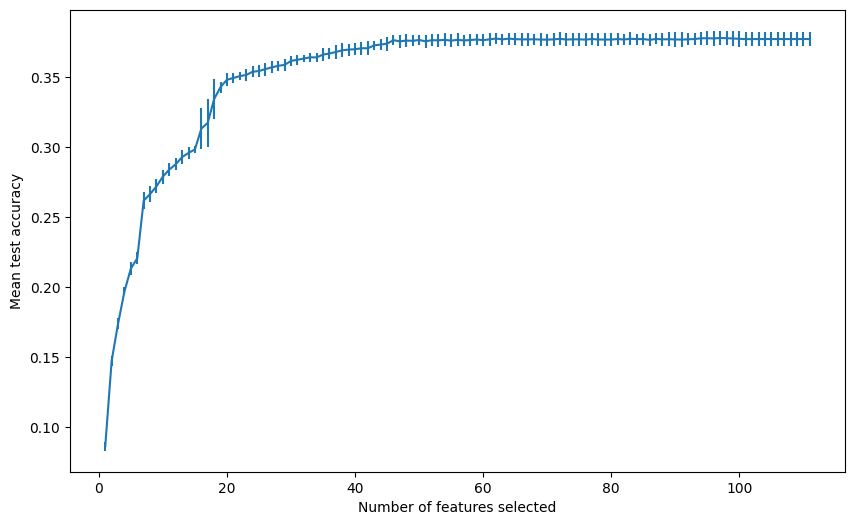

In [29]:
n_scores = len(rfe.cv_results_["mean_test_score"])
plt.figure(figsize=(10, 6))
plt.xlabel("Number of features selected")
plt.ylabel("Mean test accuracy")
plt.errorbar(
    range(1, n_scores + 1),
    rfe.cv_results_["mean_test_score"],
    yerr=rfe.cv_results_["std_test_score"],
)
plt.show()

In [30]:
model = XGBRegressor()
rfe = RFE(estimator=model, n_features_to_select=50, step=1)
rfe.fit(X, y)

# Get the list of selected feature names
selected_features = X.columns[rfe.support_]

selected_features


Index(['BusinessAcceptsCreditCards', 'RestaurantsDelivery', 'OutdoorSeating',
       'BikeParking', 'RestaurantsTakeOut', 'ByAppointmentOnly', 'Caters',
       'WheelchairAccessible', 'GoodForKids', 'DogsAllowed',
       'RestaurantsTableService', 'RestaurantsGoodForGroups', 'HasTV',
       'DriveThru', 'BusinessAcceptsBitcoin', 'AcceptsInsurance', 'street',
       'lot', 'hipster', 'divey', 'trendy', 'classy', 'casual', 'lunch',
       'dinner', 'brunch', 'breakfast', 'dj', 'WiFi_free', 'WiFi_no_info',
       'hours_open', 'businesses_in_proximity', 'average_score_proximity',
       'RestaurantsPriceRange2_1', 'RestaurantsPriceRange2_2',
       'RestaurantsPriceRange2_3', 'RestaurantsPriceRange2_4',
       'RestaurantsPriceRange2_nan', 'Alcohol_beer_and_wine',
       'Alcohol_full_bar', 'Alcohol_nan', 'RestaurantsAttire_casual',
       'RestaurantsAttire_nan', 'NoiseLevel_average', 'NoiseLevel_loud',
       'NoiseLevel_quiet', 'NoiseLevel_very_loud', 'NoiseLevel_nan',
       'BYOBCork

In [31]:
param_distributions = {
    "max_depth": np.arange(1, 10),
    "learning_rate": np.linspace(1e-4, 1e-1, 20),
    "n_estimators": np.arange(50, 600, 50),
    "subsample": np.linspace(0.1, 1.0, 10),
    "colsample_bytree": np.linspace(0.5, 1.0, 5),
    "min_child_weight": np.arange(1, 10),
    "gamma": np.arange(0, 5),
    "reg_alpha": np.linspace(0.0, 1.0, 11),
    "reg_lambda": np.linspace(0.0, 1.0, 11),
}

model = XGBRegressor()
random_search = RandomizedSearchCV(
    model,
    param_distributions,
    n_iter=50,
    cv=5,
    random_state=42,
    verbose=1,
    n_jobs=-1,
    scoring="neg_mean_absolute_error",
)

random_search.fit(X[selected_features], y)

print("Best MAE:", -random_search.best_score_)

print("Best params:", random_search.best_params_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best MAE: 1.4341406640179613
Best params: {'subsample': 0.7000000000000001, 'reg_lambda': 0.1, 'reg_alpha': 0.5, 'n_estimators': 550, 'min_child_weight': 8, 'max_depth': 8, 'learning_rate': 0.05793684210526316, 'gamma': 4, 'colsample_bytree': 0.5}


In [32]:
model = XGBRegressor(**random_search.best_params_)

cv_results = cross_validate(
    model, X, y, cv=5, scoring=["neg_mean_absolute_error", "r2", "neg_mean_absolute_percentage_error"], return_train_score=True
)

print("MAE Train:", cv_results["train_neg_mean_absolute_error"])
print("MAE Test:", cv_results["test_neg_mean_absolute_error"])
print("Mean MAE Test:", cv_results["test_neg_mean_absolute_error"].mean())
print("-------------------")
print("R2 Train:", cv_results["train_r2"])
print("R2 Test:", cv_results["test_r2"])
print("Mean R2 Test:", cv_results["test_r2"].mean())
print("-------------------")
print("MAPE Train:", cv_results["train_neg_mean_absolute_percentage_error"])
print("MAPE Test:", cv_results["test_neg_mean_absolute_percentage_error"])
print("Mean MAPE Test:", cv_results["test_neg_mean_absolute_percentage_error"].mean())

MAE Train: [-1.32922404 -1.32811761 -1.33263934 -1.33089085 -1.3306582 ]
MAE Test: [-1.43650963 -1.43684107 -1.42165438 -1.43416086 -1.42671835]
Mean MAE Test: -1.4311768578692257
-------------------
R2 Train: [0.46226647 0.46375527 0.46083202 0.4597295  0.46202356]
R2 Test: [0.38585681 0.38030043 0.39082347 0.39258509 0.38531486]
Mean R2 Test: 0.3869761312543448
-------------------
MAPE Train: [-0.15316502 -0.15286484 -0.15347796 -0.15326585 -0.15330074]
MAPE Test: [-0.16427287 -0.16520962 -0.16296801 -0.16480111 -0.16343617]
Mean MAPE Test: -0.16413755777471822


In [33]:
model = XGBRegressor(**random_search.best_params_)

cv_results = cross_validate(
    model, X[selected_features], y, cv=5, scoring=["neg_mean_absolute_error", "r2", "neg_mean_absolute_percentage_error"], return_train_score=True
)

print("MAE Train:", cv_results["train_neg_mean_absolute_error"])
print("MAE Test:", cv_results["test_neg_mean_absolute_error"])
print("Mean MAE Test:", cv_results["test_neg_mean_absolute_error"].mean())
print("-------------------")
print("R2 Train:", cv_results["train_r2"])
print("R2 Test:", cv_results["test_r2"])
print("Mean R2 Test:", cv_results["test_r2"].mean())
print("-------------------")
print("MAPE Train:", cv_results["train_neg_mean_absolute_percentage_error"])
print("MAPE Test:", cv_results["test_neg_mean_absolute_percentage_error"])
print("Mean MAPE Test:", cv_results["test_neg_mean_absolute_percentage_error"].mean())

MAE Train: [-1.33360752 -1.33230213 -1.3373058  -1.33440047 -1.33503555]
MAE Test: [-1.43675509 -1.43903101 -1.42471885 -1.43849613 -1.43170224]
Mean MAE Test: -1.4341406640179613
-------------------
R2 Train: [0.46068335 0.46170048 0.4591509  0.4586992  0.4607888 ]
R2 Test: [0.38575969 0.37872107 0.38866467 0.39050274 0.38244765]
Mean R2 Test: 0.3852191645365968
-------------------
MAPE Train: [-0.15352016 -0.1531985  -0.15387359 -0.15348257 -0.15359487]
MAPE Test: [-0.16426854 -0.16541772 -0.16328727 -0.16519373 -0.16385502]
Mean MAPE Test: -0.16440445644422


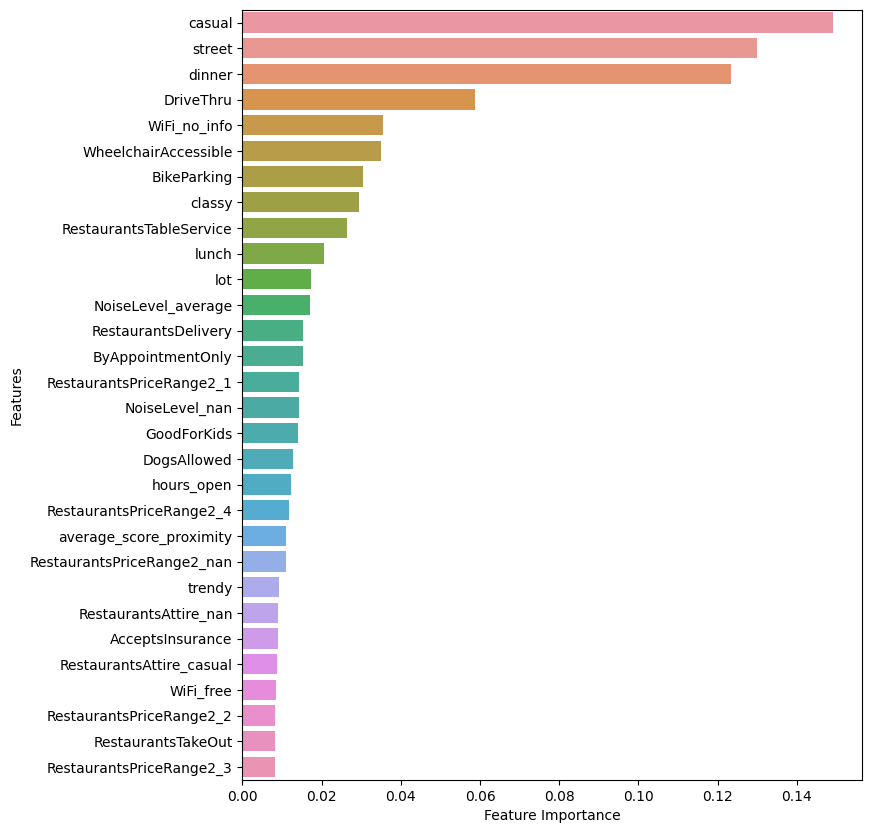

In [34]:
model.fit(X[selected_features], y)

# feature importance
importances = pd.Series(model.feature_importances_, index=X[selected_features].columns)
importances = importances.sort_values(ascending=False)[:30]

plt.figure(figsize=(8, 10))
sns.barplot(x=importances, y=importances.index,)
plt.xlabel("Feature Importance")
plt.ylabel("Features")

plt.show()

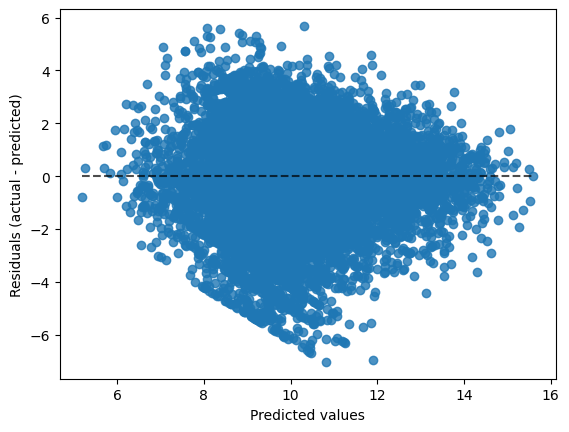

In [35]:
#train test split
X_train, X_test, y_train, y_test = train_test_split(X[selected_features], y, test_size=0.1, random_state=42)

model = XGBRegressor(**random_search.best_params_)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
display = PredictionErrorDisplay(y_true=y_test, y_pred=y_pred)
display.plot()
plt.show()


In [36]:
explainer = dx.Explainer(model, X[selected_features], y, label="XGBoost Model")

Preparation of a new explainer is initiated

  -> data              : 119698 rows 50 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 119698 values
  -> model_class       : xgboost.sklearn.XGBRegressor (default)
  -> label             : XGBoost Model
  -> predict function  : <function yhat_default at 0x00000253C61A1E40> will be used (default)
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 4.63, mean = 10.3, max = 16.1
  -> model type        : regression will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -7.3, mean = -0.00222, max = 6.64
  -> model_info        : package xgboost

A new explainer has been created!


In [37]:
fi = explainer.model_parts()
fi.plot()

In [38]:
pb = explainer.predict_parts(X[selected_features].iloc[0])
pb.plot()

In [39]:
pdp = explainer.model_profile(type='partial')
pdp.plot()

Calculating ceteris paribus: 100%|██████████| 50/50 [00:08<00:00,  5.95it/s]


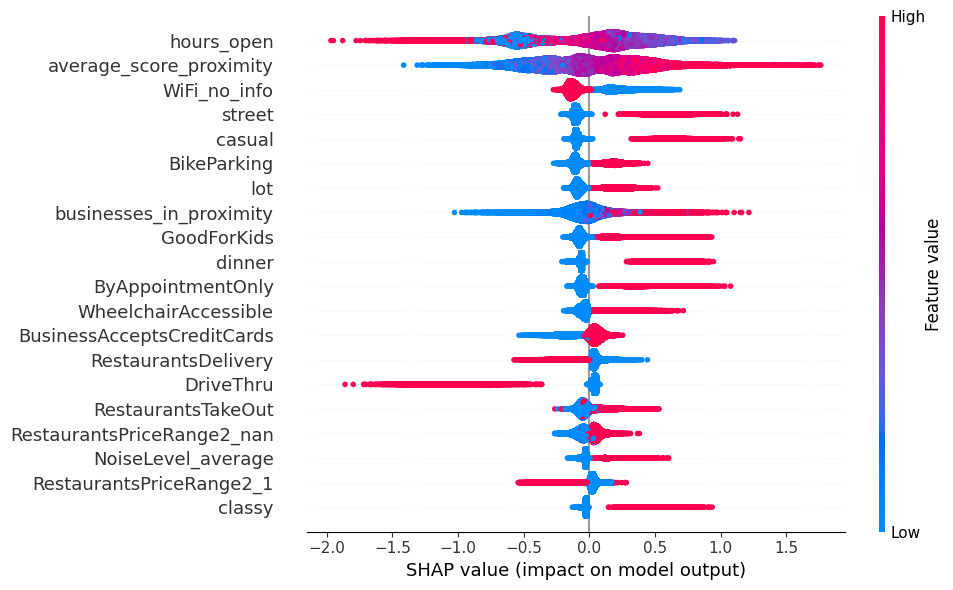

In [40]:
shap_explainer = shap.TreeExplainer(
    model,
)
shap_values = shap_explainer.shap_values(X[selected_features])
shap.summary_plot(shap_values, X[selected_features], plot_size=(10, 6))

In [41]:
# CATEGORIES
business_df["categories"] = business_df["categories"].fillna("Missing")
# Split the list of categories and create a new column for each category
categories = business_df["categories"].str.get_dummies(sep=",")
# Add a prefix to the column names to avoid duplicate column names
categories = categories.add_prefix("categories_")
# Join the new columns to the original DataFrame
business_df = business_df.join(categories)

In [42]:
X = business_df.drop(
    ["business_success_score"], axis=1
)

y = business_df["business_success_score"]

X.drop(
    [
        "latitude",
        "longitude",
        "business_id",
        "review_count",
        "stars",
        "is_open",
        "name",
        "address",
        "city",
        "state",
        "postal_code",
        "categories",
        "hours",
    ],

    axis=1,
    inplace=True,
)

In [43]:
X.shape

(119698, 2522)

In [44]:
def process_and_dummify_column(df, column_name):
    df[column_name] = (
        df[column_name]
        .apply(
            lambda x: x.replace("u'", "").replace("'", "") if isinstance(x, str) else x
        )
        .replace({"None": np.nan, "NaN": np.nan, "True": True, "False": False})
    )

    unique_values = df[column_name].dropna().unique()
    if set(unique_values) <= {True, False}:
        df[column_name] = df[column_name].fillna(False).astype(int)
    else:
        dummies = pd.get_dummies(df[column_name], prefix=column_name, dummy_na=True)
        df = df.drop(column_name, axis=1).join(dummies)

    return df

In [45]:
for column in X.select_dtypes(include="object").columns:
    X = process_and_dummify_column(X, column)

In [46]:
X

,BusinessAcceptsCreditCards,RestaurantsDelivery,OutdoorSeating,BikeParking,RestaurantsTakeOut,ByAppointmentOnly,Caters,WheelchairAccessible,GoodForKids,RestaurantsReservations,CoatCheck,DogsAllowed,RestaurantsTableService,RestaurantsGoodForGroups,HasTV,HappyHour,DriveThru,BusinessAcceptsBitcoin,AcceptsInsurance,GoodForDancing,BYOB,Corkage,Open24Hours,RestaurantsCounterService,garage,street,validated,lot,valet,touristy,hipster,romantic,divey,intimate,trendy,upscale,classy,casual,monday,tuesday,wednesday,thursday,friday,saturday,sunday,dessert,latenight,lunch,dinner,brunch,...,categories_Wholesalers,categories_Wigs,categories_Wildlife Control,categories_Wildlife Hunting Ranges,categories_Wills,categories_Window Washing,categories_Windows Installation,categories_Windshield Installation & Repair,categories_Wine Bars,categories_Wine Tasting Classes,categories_Wine Tasting Room,categories_Wine Tours,categories_Wineries,categories_Women's Clothing,categories_Workers Compensation Law,categories_Wraps,categories_Yelp Events,categories_Yoga,categories_Ziplining,categories_Zoos,RestaurantsPriceRange2_1,RestaurantsPriceRange2_2,RestaurantsPriceRange2_3,RestaurantsPriceRange2_4,RestaurantsPriceRange2_nan,Alcohol_beer_and_wine,Alcohol_full_bar,Alcohol_none,Alcohol_nan,RestaurantsAttire_casual,RestaurantsAttire_dressy,RestaurantsAttire_formal,RestaurantsAttire_nan,NoiseLevel_average,NoiseLevel_loud,NoiseLevel_quiet,NoiseLevel_very_loud,NoiseLevel_nan,Smoking_no,Smoking_outdoor,Smoking_yes,Smoking_nan,BYOBCorkage_no,BYOBCorkage_yes_corkage,BYOBCorkage_yes_free,BYOBCorkage_nan,AgesAllowed_18plus,AgesAllowed_21plus,AgesAllowed_allages,AgesAllowed_nan
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1
3,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1
4,1,0,0,1,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1
5,1,1,1,0,1,0,0,1,1,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1
6,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150341,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1
150342,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1
150343,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1
150344,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1


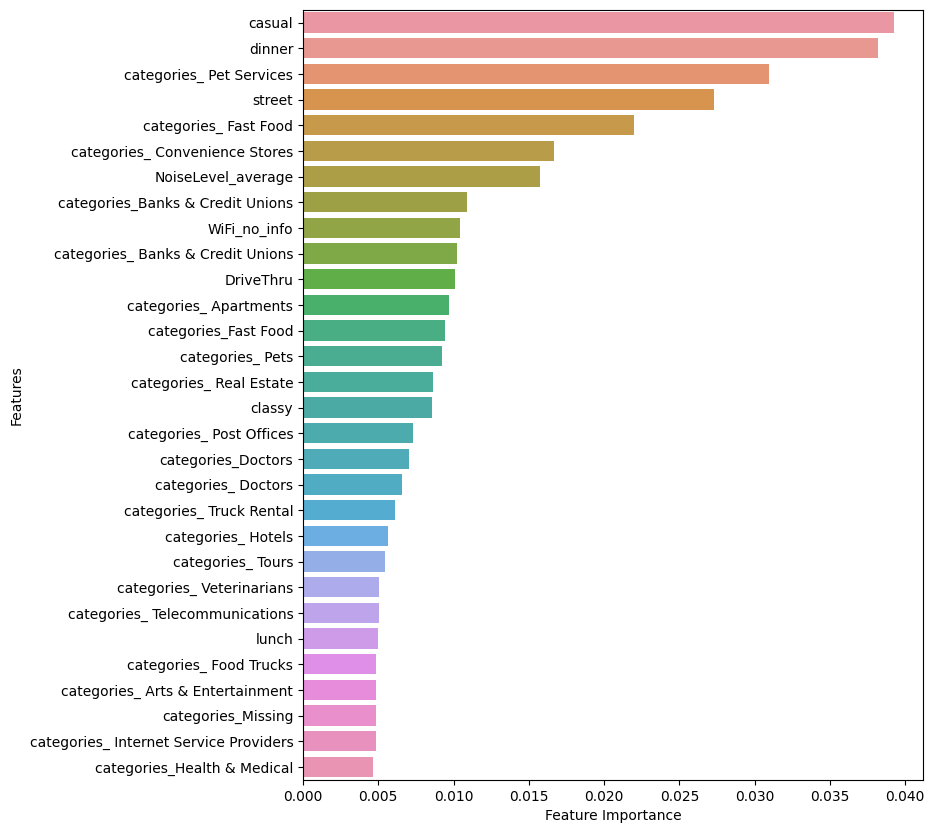

In [47]:
model = XGBRegressor()

model.fit(X, y)

# feature importance
importances = pd.Series(model.feature_importances_, index=X.columns)
importances = importances.sort_values(ascending=False)[:30]

plt.figure(figsize=(8, 10))
sns.barplot(x=importances, y=importances.index,)
plt.xlabel("Feature Importance")
plt.ylabel("Features")

plt.show()

In [48]:
# fit model on important features
model = XGBRegressor()

model.fit(X[importances.index], y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

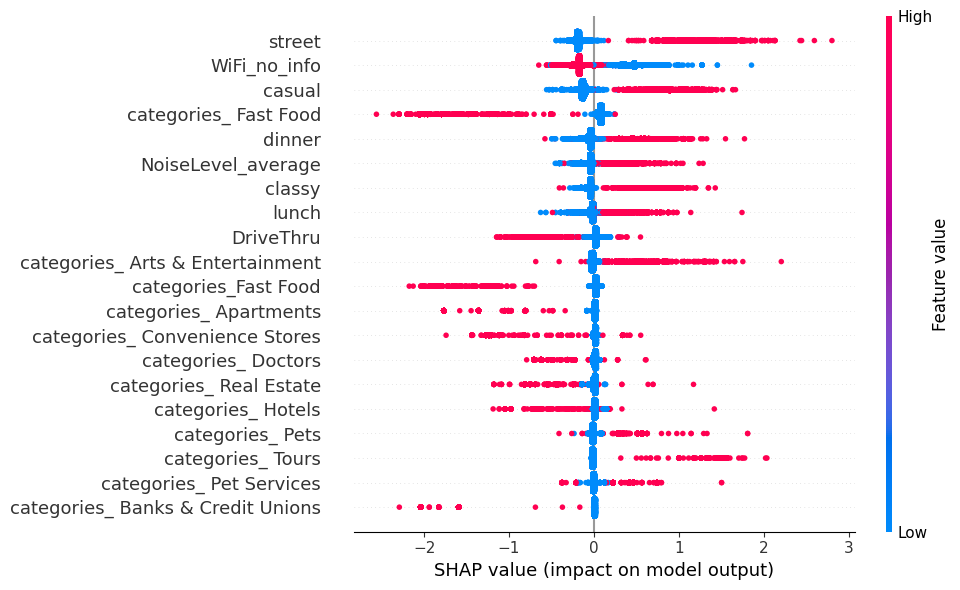

In [49]:
shap_explainer = shap.TreeExplainer(
    model,
)
shap_values = shap_explainer.shap_values(X[importances.index])
shap.summary_plot(shap_values, X[importances.index], plot_size=(10, 6))